# Video Stabilization Using Point Feature Matching in OpenCV

* This notebook is an implementation of algorithm of Point Feature Matching.

* We used original [paper.](https://www.researchgate.net/publication/321589788_Video_Stabilization_Using_Point_Feature_Matching)

* We decided to use our own small (~5 videos) database of shaky videos.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
cv2.__version__

'3.4.2'

# Get data

In [4]:
# Read input video
cap = cv2.VideoCapture('data/video.mp4') 

# Params for video

### Number of frames

In [5]:
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
n_frames

1362

### Width and height of video

In [6]:
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print('Width is {} and Height is {}'.format(w,h))

Width is 720 and Height is 480


### FPS

In [7]:
fps = cap.get(cv2.CAP_PROP_FPS)
fps

29.1494856392769

### Codec

In [8]:
fourcc = cv2.VideoWriter_fourcc(*'MJPG')

----

# Output video

In [9]:
out = cv2.VideoWriter('output_data/video_out.avi', fourcc, fps, (2 * w, h))

# First frame

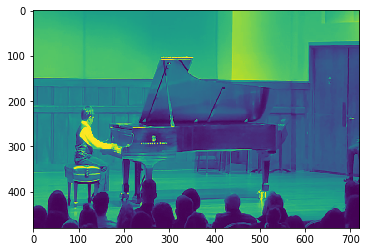

In [10]:
presence, frame = cap.read()
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
plt.imshow(frame_gray)
plt.show()

# First 200 Key Points for first frame, using goodFeaturesToTrack

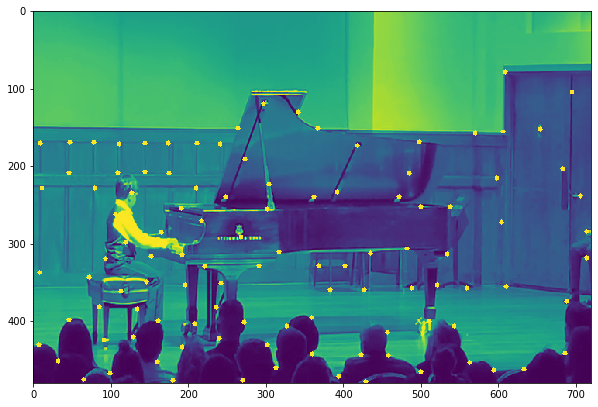

In [11]:
# Read first frame
presence, prev_frame = cap.read() 
 
# Convert frame to grayscale
prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY) 


prev_frame_pts = cv2.goodFeaturesToTrack(prev_frame_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)
prev_corners = np.int0(prev_frame_pts)

for i in prev_corners:
    x,y = i.ravel()
    img = cv2.circle(prev_frame_gray,(x,y),3,255,-1)
    
plt.figure(figsize = (10,15))
plt.imshow(img)
plt.show()

## Lucas Kanade Optical Flow for first 40 frames

In [12]:
out_firstN = cv2.VideoWriter('output_data/first_N_frames_move.avi', fourcc, fps, (w, h))

In [11]:
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(200,3))

# Create a mask image for drawing purposes
mask = np.zeros_like(prev_frame)

ind = 0
FRAMES = 40

while(ind <= FRAMES):
    ret,next_frame = cap.read()
    next_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    next_frame_pts, st, err = cv2.calcOpticalFlowPyrLK(prev_frame_gray, next_frame_gray, prev_frame_pts, 
                                                       None, **lk_params)

    # Select good points
    good_new = next_frame_pts[st==1]
    good_old = prev_frame_pts[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        
    img = cv2.add(frame,mask)

    cv2.imshow('Optical flow for first {} frames'.format(FRAMES),img)
    
    k = cv2.waitKey(30) & 0xFF
    if k == 27:
        break
    
    # Now update the previous frame and previous points
    prev_frame_gray = next_frame_gray.copy()
    prev_frame_pts = good_new.reshape(-1,1,2)
    
    ind+=1

cap.release()
cv2.destroyAllWindows()

In [7]:
# The larger the more stable the video, but less reactive to sudden panning
SMOOTHING_RADIUS=50 

# Read first frame
presence, prev = cap.read() 
 
# Convert frame to grayscale
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY) 

# Pre-define transformation-store array
transforms = np.zeros((n_frames-1, 3), np.float32) 

for i in range(n_frames-2):
    
    # Detect feature points in previous frame
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)

    # Read next frame
    success, curr = cap.read() 
    if not success: 
        break 

    # Convert to grayscale
    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 

    # Calculate optical flow (i.e. track feature points)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 

    # Sanity check
    assert prev_pts.shape == curr_pts.shape 

    # Filter only valid points
    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    #Find transformation matrix
    m = cv2.estimateRigidTransform(prev_pts, curr_pts, fullAffine=False) 
    
    # Extract traslation
    dx = m[0,2]
    dy = m[1,2]

    # Extract rotation angle
    da = np.arctan2(m[1,0], m[0,0])

    # Store transformation
    transforms[i] = [dx,dy,da]

    # Move to next frame
    prev_gray = curr_gray

    print("Frame: " + str(i) +  "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts)))

Frame: 0/250 -  Tracked points : 200
Frame: 1/250 -  Tracked points : 200
Frame: 2/250 -  Tracked points : 200
Frame: 3/250 -  Tracked points : 200
Frame: 4/250 -  Tracked points : 200
Frame: 5/250 -  Tracked points : 200
Frame: 6/250 -  Tracked points : 200
Frame: 7/250 -  Tracked points : 200
Frame: 8/250 -  Tracked points : 200
Frame: 9/250 -  Tracked points : 200
Frame: 10/250 -  Tracked points : 200
Frame: 11/250 -  Tracked points : 200
Frame: 12/250 -  Tracked points : 200
Frame: 13/250 -  Tracked points : 200
Frame: 14/250 -  Tracked points : 200
Frame: 15/250 -  Tracked points : 200
Frame: 16/250 -  Tracked points : 200
Frame: 17/250 -  Tracked points : 200
Frame: 18/250 -  Tracked points : 200
Frame: 19/250 -  Tracked points : 200
Frame: 20/250 -  Tracked points : 200
Frame: 21/250 -  Tracked points : 200
Frame: 22/250 -  Tracked points : 200
Frame: 23/250 -  Tracked points : 200
Frame: 24/250 -  Tracked points : 200
Frame: 25/250 -  Tracked points : 200
Frame: 26/250 -  Track

Frame: 214/250 -  Tracked points : 200
Frame: 215/250 -  Tracked points : 200
Frame: 216/250 -  Tracked points : 200
Frame: 217/250 -  Tracked points : 200
Frame: 218/250 -  Tracked points : 200
Frame: 219/250 -  Tracked points : 200
Frame: 220/250 -  Tracked points : 200
Frame: 221/250 -  Tracked points : 200
Frame: 222/250 -  Tracked points : 200
Frame: 223/250 -  Tracked points : 200
Frame: 224/250 -  Tracked points : 200
Frame: 225/250 -  Tracked points : 200
Frame: 226/250 -  Tracked points : 200
Frame: 227/250 -  Tracked points : 200
Frame: 228/250 -  Tracked points : 200
Frame: 229/250 -  Tracked points : 200
Frame: 230/250 -  Tracked points : 200
Frame: 231/250 -  Tracked points : 200
Frame: 232/250 -  Tracked points : 200
Frame: 233/250 -  Tracked points : 200
Frame: 234/250 -  Tracked points : 200
Frame: 235/250 -  Tracked points : 200
Frame: 236/250 -  Tracked points : 200
Frame: 237/250 -  Tracked points : 200
Frame: 238/250 -  Tracked points : 200
Frame: 239/250 -  Tracked

# Trajectory

In [8]:
# Compute trajectory using cumulative sum of transformations
trajectory = np.cumsum(transforms, axis=0) 

In [9]:
def movingAverage(curve, radius): 
    window_size = 2 * radius + 1
    # Define the filter 
    f = np.ones(window_size)/window_size 
    # Add padding to the boundaries 
    curve_pad = np.lib.pad(curve, (radius, radius), 'edge') 
    # Apply convolution 
    curve_smoothed = np.convolve(curve_pad, f, mode='same') 
    # Remove padding 
    curve_smoothed = curve_smoothed[radius:-radius]
    # return smoothed curve
    return curve_smoothed

In [11]:
def smooth(trajectory): 
    smoothed_trajectory = np.copy(trajectory) 
    # Filter the x, y and angle curves
    for i in range(3):
        smoothed_trajectory[:,i] = movingAverage(trajectory[:,i], radius=SMOOTHING_RADIUS)

    return smoothed_trajectory

# Create variable to store smoothed trajectory
smoothed_trajectory = smooth(trajectory) 

In [12]:
# Calculate difference in smoothed_trajectory and trajectory
difference = smoothed_trajectory - trajectory
 
# Calculate newer transformation array
transforms_smooth = transforms + difference

In [13]:
def fixBorder(frame):
    s = frame.shape
    # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

In [15]:
# Reset stream to first frame 
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) 
 
# Write n_frames-1 transformed frames
for i in range(n_frames-2):
    # Read next frame
    success, frame = cap.read() 
    if not success:
        break

    # Extract transformations from the new transformation array
    dx = transforms_smooth[i,0]
    dy = transforms_smooth[i,1]
    da = transforms_smooth[i,2]

    # Reconstruct transformation matrix accordingly to new values
    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy

    # Apply affine wrapping to the given frame
    frame_stabilized = cv2.warpAffine(frame, m, (w,h))

    # Fix border artifacts
    frame_stabilized = fixBorder(frame_stabilized) 

    # Write the frame to the file
    frame_out = cv2.hconcat([frame, frame_stabilized])

    # If the image is too big, resize it.
    if(frame_out.shape[1] > 1920): 
        frame_out = cv2.resize(frame_out, (int(frame_out.shape[1]/2), int(frame_out.shape[0]/2)))

    cv2.imshow("Before and After", frame_out)
    cv2.waitKey(10)
    out.write(frame_out)

In [1]:
# Release video
cap.release()
out.release()
# Close windows
cv2.destroyAllWindows()

NameError: name 'cap' is not defined